# Eindhoven University of Technology. Mathematics & Computer Science
## Data Science Master track
## Recommender Systems
Lecturer: Dr. Vlado Menkovski
- Franziska Boenisch
- Adriano Cardace 
- Camilo Montenegro Hernandez

 


### Word embeddings
Build embeddings with a keras implementation where the embedding vector is of length 50, 150 and 300. Use the Alice in Wonderland text book for training.
1. Using the Skipgram model
2. Using CBOW model
3. Analyze the different word embeddings
    - Implement your own function to perform the analogy task with. Do not use existing libraries for this task such as Gensim. Your function should be able to answer whether an anaology as in the example given in the pdf-file is true.
    - Compare the performance on the analogy task between the word embeddings
    - Visualize your results and interpret your results
4. Discuss:
    - What are the main advantages of CBOW and Skipgram?
    - What are the main drawbacks of CBOW and Skipgram?


In [ ]:
import numpy as np
np.random.seed(13) #TODO Check if this is used for sgd
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Reshape, Lambda
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing import sequence
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors as nn
from itertools import islice
from matplotlib import pylab
from __future__ import division
from sklearn.metrics.pairwise import cosine_distances
import operator

In [ ]:
# DO NOT Modify the lines in this cell
path = 'alice.txt'
corpus = open(path).readlines()

corpus = [sentence for sentence in corpus if sentence.count(" ") >= 2]

tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'+"'")
tokenizer.fit_on_texts(corpus)
corpus = tokenizer.texts_to_sequences(corpus)
nb_samples = sum(len(s) for s in corpus)
V = len(tokenizer.word_index) + 1

# Is this something they need to change?
#dim = 100
dims = [50,150,300]
window_size = 2
# window_size_corpus = 4

# Skipgram

In [ ]:
#prepare data for skipgram
def generate_data_skipgram(corpus, window_size, V):
  trainPairs = []
  # iterate over all sentences to build the training pairs
  for sentence in corpus:
    # let every word from the sentence be the center word
    for center_word_pos in range(len(sentence)):
        # get the index of the word within the entire corpus, not only sentence
        center_word_idx = sentence[center_word_pos]
        # take the words within the window size as context
        for w in range(-window_size, window_size + 1):
            # position of the content word
            context_word_pos = center_word_pos + w
            # make soure not jump outside of a sentence
            if context_word_pos < 0 or context_word_pos >= len(sentence) or center_word_pos == context_word_pos:
                continue
            # get the index of the word within the entire corpus, not only sentence
            context_word_idx = sentence[context_word_pos]
            # add word and context to the training pairs
            trainPairs.append((center_word_idx, context_word_idx))

  # initialize empty lists
  x=[]
  y=[]
  all_outY = []
  # iterate over all training pairs
  for pair in trainPairs:
    # for the one hot encoding
    all_outY = np_utils.to_categorical(pair[1],V)
    # append the word and the one hot encoding
    x.append(pair[0])
    y.append(all_outY)
    
  # return the word and the matrix with shape (number of train pairs * vocab size)
  return np.array(x) , np.array(y).reshape(-1, V)   

In [ ]:
#training data
x,y = generate_data_skipgram(corpus,window_size,V)

In [ ]:
#create Skipgram model

skipgramsModels = []
for dim in dims:
  print("Skipgram model with dimensions:",dim)
  skipgram = Sequential()
  #if you use embedding (instead of dense layer) input doesn't have to be one hot encoded
  skipgram.add(Embedding(V, dim, input_length=1, embeddings_initializer='glorot_uniform')) 
  # respape the output of the embedding layer
  skipgram.add(Reshape((dim, )))
  skipgram.add(Dense(V, activation='softmax', kernel_initializer='uniform'))

  # compile the model
  skipgram.compile(loss='categorical_crossentropy', optimizer='adadelta')
  skipgram.summary()
  skipgramsModels.append(skipgram)

  # show model
  #from IPython.display import SVG
  #from keras.utils.vis_utils import model_to_dot

  #SVG(model_to_dot(skipgram, show_shapes=True, show_layer_names=False, 
  #                 rankdir='TB').create(prog='dot', format='svg'))
  



Skipgram model with dimensions: 50
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 1, 50)             127850    
_________________________________________________________________
reshape_4 (Reshape)          (None, 50)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 2557)              130407    
Total params: 258,257
Trainable params: 258,257
Non-trainable params: 0
_________________________________________________________________
Skipgram model with dimensions: 150
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 1, 150)            383550    
_________________________________________________________________
reshape_5 (Reshape)          (None, 150)               0         

In [ ]:
#train Skipgram model
model = 0
for skipgram in skipgramsModels:
  print("Training Skipgram model with",dims[model], "dimensions")
  skipgram.fit(x, y, batch_size=128, epochs=10, verbose=1)
  model+=1

Training Skipgram model with 50 dimensions
Epoch 1/10
94556/94556 [==============================] - 3s 32us/step - loss: 7.5069
Epoch 2/10
94556/94556 [==============================] - 3s 28us/step - loss: 6.6804
Epoch 3/10
94556/94556 [==============================] - 3s 28us/step - loss: 6.2760
Epoch 4/10
94556/94556 [==============================] - 3s 28us/step - loss: 6.0971
Epoch 5/10
94556/94556 [==============================] - 3s 28us/step - loss: 5.9929
Epoch 6/10
94556/94556 [==============================] - 3s 28us/step - loss: 5.9221
Epoch 7/10
94556/94556 [==============================] - 3s 28us/step - loss: 5.8703
Epoch 8/10
94556/94556 [==============================] - 3s 30us/step - loss: 5.8297
Epoch 9/10
94556/94556 [==============================] - 3s 31us/step - loss: 5.7964
Epoch 10/10
94556/94556 [==============================] - 3s 31us/step - loss: 5.7681
Training Skipgram model with 150 dimensions
Epoch 1/10
94556/94556 [============================

In [ ]:
  # using the word2vec model make two tables
  # one to map from words to index and the other one from index to word
word2idx = tokenizer.word_index
idx2word = {v: k for k, v in word2idx.items()}

#Implement your own analogy function
model = 0
for skipgram in skipgramsModels:
  print("Skipgram model with dimensions:",dims[model])
  weights = skipgram.get_weights()[0]
  weights.shape
  
  idx2emb = {}
  for word in word2idx.keys():
    wid = word2idx[word]
    vec_in = np.zeros(V)
    #one-hot encoding
    vec_in[wid] = 1
    vec_emb = np.dot(vec_in, weights).reshape(1,-1)
    #print(vec_emb)
    idx2emb[wid] = vec_emb

  def embed2Words(word1,word2):
    """function to calculate the cosine distance of two words"""
    # look the index of the word up
    wid1 = word2idx[word1]
    wid2 = word2idx[word2]
    # extract the embedding for the word
    source_emb = idx2emb[wid1]
    target_emb = idx2emb[wid2]
    # calculate the distance
    distance = cosine_distances(source_emb,target_emb)  
    return distance.item()

  # see similarities between queen and king
  # queen = embed('king')-embed('man')+embed('woman')
  # 0 = embed('king')-embed('man')+embed('woman')-embed('queen')
  val1 = embed2Words('king','man')
  val2 = embed2Words('woman','queen')
  print("Analogy function:")
  print("Queen = king - man + woman")
  print("Is the same as:")
  print("0 = king - man + woman - queen")
  print("The expected value is 0")
  print("Obteined value using skipgram with", dims[model],"dimensions:",val1+val2)

  # just an example: woman and man should be not so far
  print("Just an example: woman and man should be not so far")
  print("Distance:",embed2Words('woman','man'))
  def similar_words(word):
    """function that given a certain word returns us the 10 most similar words"""
    # find the index of the word
    wid = word2idx[word]
    # get its embedding
    source_emb = idx2emb[wid]
    distances = []
    # iterate over all other words in the vocabulary
    for i in range(1, V):
        # if we are at the word itself: skip
        if i == wid:
            continue
        # get the embedding for the target word
        target_emb = idx2emb[i]
        # calculate the distance between the two words
        distances.append(((wid, i), cosine_distances(source_emb, target_emb)))
    # sort the list of distances and keep the 10 first
    sorted_distances = sorted(distances, key=operator.itemgetter(1))[0:10]
    predictions = [idx2word[x[0][1]] for x in sorted_distances]
    
    # format the output
    print("{:s} => {:s}".format(word, ", ".join(predictions)))
    return predictions
    
  predictions1 = similar_words("queen")
  predictions2 = similar_words("king")
  predictions3 = similar_words("rabbit")
  model +=1
  print("\n")

Skipgram model with dimensions: 50
Analogy function:
Queen = king - man + woman
Is the same as:
0 = king - man + woman - queen
The expected value is 0
Obteined value using skipgram with 50 dimensions: 0.993225119735628
Just an example: woman and man should be not so far
Distance: 0.42461832344486006
queen => duchess, dormouse, king, gryphon, march, hatter, white, caterpillar, other, rabbit
king => gryphon, hatter, duchess, queen, caterpillar, dormouse, march, hare, cat, white
rabbit => dormouse, white, queen, same, other, by, thing, duchess, first, gloves


Skipgram model with dimensions: 150
Analogy function:
Queen = king - man + woman
Is the same as:
0 = king - man + woman - queen
The expected value is 0
Obteined value using skipgram with 150 dimensions: 1.192174857581819
Just an example: woman and man should be not so far
Distance: 0.483390223006814
queen => duchess, dormouse, king, gryphon, hatter, caterpillar, first, footman, who, words
king => duchess, gryphon, caterpillar, hatte

Total words: 18 	Word Embedding shapes: (18, 300)
(18, 2)


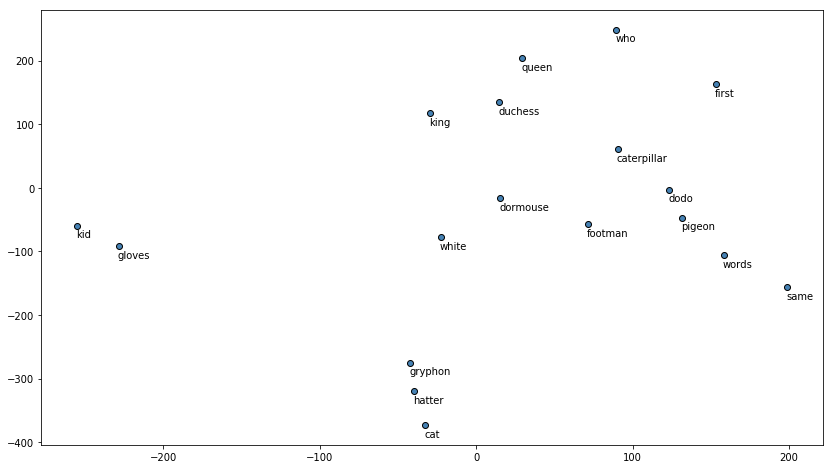

In [ ]:
import matplotlib.pyplot as plt

#Visualization results trained word embeddings
from sklearn.manifold import TSNE

predictions = predictions1 + predictions2 + predictions3
#remove duplicated words from the predictions list
predictions = set(predictions)

#put all the previous similar word into the same list
words_ids = [word2id[w] for w in predictions]

word_vectors = np.array([weights[idx] for idx in words_ids])
print('Total words:', len(predictions), '\tWord Embedding shapes:', word_vectors.shape)

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors)
print(T.shape)
labels = predictions

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='steelblue', edgecolors='k')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
  plt.annotate(label, xy=(x, y), xytext=(-1, -12), textcoords='offset points')

As we can see from the plot there some clusters (e.g. queen, duchess and king are close). The same holds for animals (e.g. dormhouse, caterpillar, dodo and pigeon)  

# CBOW

In [ ]:
#prepare data for CBOW

def generate_data_CBOW(corpus, window_size, vocab_size):
  # the context are the words to the left and right (which is double the window size)
  context_length = window_size*2
  x = []
  y = []
  # iterate over all sentences
  for sentence in corpus:
      sentence_length = len(sentence)
      for i, global_index in enumerate(sentence):
        # set the boundaries for the context
          context_words = []
          label_word   = []            
          start = i - window_size
          end = i + window_size + 1
          # extract the context words within the boundaries
          context_words = [[sentence[j] for j in range(start, end) 
                                              if 0 <= j < sentence_length and j != i]]
          # assign the label word its global index from the entire corpus
          label_word = global_index
          # add training pairs of padded context words ...
          x.append(sequence.pad_sequences(context_words, maxlen=context_length))
          # ... and a one hot representation of the word
          y.append(np_utils.to_categorical(label_word, vocab_size))
  return (np.array(x).reshape(-1, context_length), np.array(y))

In [ ]:
#get x and y's for training data
x,y = generate_data_CBOW(corpus,window_size,V)

In [ ]:
#create CBOW model
cbowsModels = []
for dim in dims:
  print("CBOW model with dimensions:",dim)
  cbow = Sequential()
  # we use an embedding layer: input size is defined by the size of vocabulary
  # output size is equal to dim
  cbow.add(Embedding(input_dim=V, output_dim=dim, input_length=window_size*2))
  # now in the second layer, we sum up everything like in the paper
  cbow.add(Lambda(lambda x: K.sum(x, axis=1), output_shape=(dim,)))
  cbow.add(Dense(V, activation='softmax'))

  #compile the model
  cbow.compile(loss='categorical_crossentropy', optimizer='adadelta')

  cbow.summary()
  cbowsModels.append(cbow)

CBOW model with dimensions: 50
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 4, 50)             127850    
_________________________________________________________________
lambda_7 (Lambda)            (None, 50)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 2557)              130407    
Total params: 258,257
Trainable params: 258,257
Non-trainable params: 0
_________________________________________________________________
CBOW model with dimensions: 150
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 4, 150)            383550    
_________________________________________________________________
lambda_8 (Lambda)            (None, 150)               0         
_______

In [ ]:
#train model
model=0
for cbow in cbowsModels:
  print("Training CBOW model with",dims[model], "dimensions")
  cbow.fit(x, y, batch_size=128, epochs=10, verbose=1)
  model+=1

Training CBOW model with 50 dimensions
Epoch 1/10
27165/27165 [==============================] - 1s 45us/step - loss: 7.3743
Epoch 2/10
27165/27165 [==============================] - 1s 32us/step - loss: 6.4409
Epoch 3/10
27165/27165 [==============================] - 1s 32us/step - loss: 6.1357
Epoch 4/10
27165/27165 [==============================] - 1s 32us/step - loss: 5.9734
Epoch 5/10
27165/27165 [==============================] - 1s 32us/step - loss: 5.8532
Epoch 6/10
27165/27165 [==============================] - 1s 32us/step - loss: 5.7529
Epoch 7/10
27165/27165 [==============================] - 1s 32us/step - loss: 5.6647
Epoch 8/10
27165/27165 [==============================] - 1s 33us/step - loss: 5.5851
Epoch 9/10
27165/27165 [==============================] - 1s 32us/step - loss: 5.5133
Epoch 10/10
27165/27165 [==============================] - 1s 33us/step - loss: 5.4475
Training CBOW model with 150 dimensions
Epoch 1/10
27165/27165 [==============================] - 1s

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166961). Check your callbacks.
  % delta_t_median)


27165/27165 [==============================] - 1s 38us/step - loss: 5.7948
Epoch 5/10
27165/27165 [==============================] - 1s 31us/step - loss: 5.6447
Epoch 6/10
27165/27165 [==============================] - 1s 31us/step - loss: 5.5195
Epoch 7/10
27165/27165 [==============================] - 1s 31us/step - loss: 5.4104
Epoch 8/10
27165/27165 [==============================] - 1s 31us/step - loss: 5.3132
Epoch 9/10
27165/27165 [==============================] - 1s 31us/step - loss: 5.2237
Epoch 10/10
27165/27165 [==============================] - 1s 31us/step - loss: 5.1427
Training CBOW model with 300 dimensions
Epoch 1/10
27165/27165 [==============================] - 1s 52us/step - loss: 7.1149
Epoch 2/10
27165/27165 [==============================] - 1s 35us/step - loss: 6.1803
Epoch 3/10
27165/27165 [==============================] - 1s 35us/step - loss: 5.8569
Epoch 4/10
27165/27165 [==============================] - 1s 35us/step - loss: 5.6426
Epoch 5/10
27165/27165 [

In [ ]:
  # using the word2vec model make two tables
  # one to map from words to index and the other one from index to word
word2idx = tokenizer.word_index
idx2word = {v: k for k, v in word2idx.items()}

#Implement your own analogy function
model = 0
for cbow in cbowsModels:
  print("cbow model with dimensions:",dims[model])
  weights = cbow.get_weights()[0]
  weights.shape
  
  idx2emb = {}
  for word in word2idx.keys():
    wid = word2idx[word]
    vec_in = np.zeros(V)
    #one-hot encoding
    vec_in[wid] = 1
    vec_emb = np.dot(vec_in, weights).reshape(1,-1)
    #print(vec_emb)
    idx2emb[wid] = vec_emb

  def embed2Words(word1,word2):
    """function to calculate the cosine distance of two words"""
    # look the index of the word up
    wid1 = word2idx[word1]
    wid2 = word2idx[word2]
    # extract the embedding for the word
    source_emb = idx2emb[wid1]
    target_emb = idx2emb[wid2]
    # calculate the distance
    distance = cosine_distances(source_emb,target_emb)  
    return distance.item()

  # see similarities between queen and king
  # queen = embed('king')-embed('man')+embed('woman')
  # 0 = embed('king')-embed('man')+embed('woman')-embed('queen')
  val1 = embed2Words('king','man')
  val2 = embed2Words('woman','queen')
  print("Analogy function:")
  print("Queen = king - man + woman")
  print("Is the same as:")
  print("0 = king - man + woman - queen")
  print("The expected value is 0")
  print("Obteined value using cbow with", dims[model],"dimensions:",val1+val2)

  # just an example: woman and man should be not so far
  print("Just an example: woman and man should be not so far")
  print("Distance:",embed2Words('woman','man'))
  def similar_words(word):
    """function that given a certain word returns us the 10 most similar words"""
    # find the index of the word
    wid = word2idx[word]
    # get its embedding
    source_emb = idx2emb[wid]
    distances = []
    # iterate over all other words in the vocabulary
    for i in range(1, V):
        # if we are at the word itself: skip
        if i == wid:
            continue
        # get the embedding for the target word
        target_emb = idx2emb[i]
        # calculate the distance between the two words
        distances.append(((wid, i), cosine_distances(source_emb, target_emb)))
    # sort the list of distances and keep the 10 first
    sorted_distances = sorted(distances, key=operator.itemgetter(1))[0:10]
    predictions = [idx2word[x[0][1]] for x in sorted_distances]
    
    # format the output
    print("{:s} => {:s}".format(word, ", ".join(predictions)))
    return predictions
    
  predictions1 = similar_words("queen")
  predictions2 = similar_words("king")
  predictions3 = similar_words("rabbit")
  model +=1
  print("\n")

cbow model with dimensions: 50
Analogy function:
Queen = king - man + woman
Is the same as:
0 = king - man + woman - queen
The expected value is 0
Obteined value using cbow with 50 dimensions: 0.8069634321276149
Just an example: woman and man should be not so far
Distance: 0.6664461685070767
queen => dormouse, duchess, gryphon, caterpillar, witness, dodo, hatter, footman, jury, words
king => caterpillar, duchess, hatter, cat, dodo, dormouse, queen, gryphon, pigeon, witness
rabbit => game, cook, baby, door, footman, words, dormouse, jury, queen, dodo


cbow model with dimensions: 150
Analogy function:
Queen = king - man + woman
Is the same as:
0 = king - man + woman - queen
The expected value is 0
Obteined value using cbow with 150 dimensions: 1.2639826169162653
Just an example: woman and man should be not so far
Distance: 0.7532480556674412
queen => duchess, caterpillar, dormouse, footman, dodo, king, pigeon, hatter, words, gryphon
king => caterpillar, duchess, hatter, cat, dormouse, g

Total words: 14 	Word Embedding shapes: (14, 300)
(14, 2)


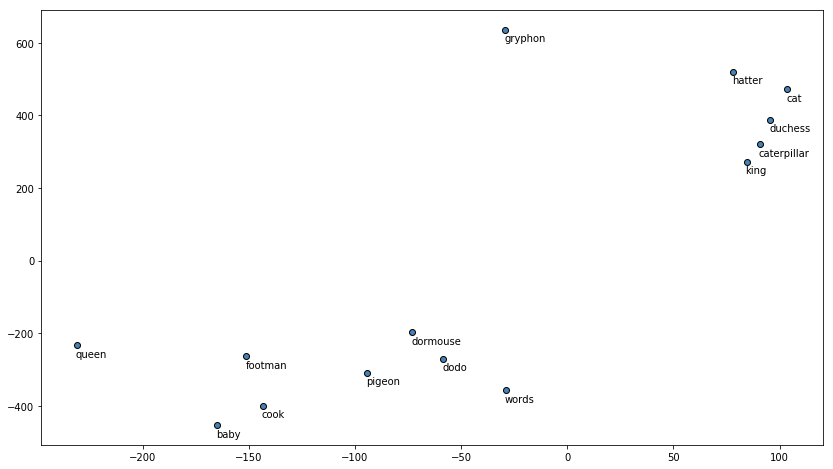

In [ ]:
import matplotlib.pyplot as plt

#Visualization results trained word embeddings
from sklearn.manifold import TSNE

predictions = predictions1 + predictions2 + predictions3
#remove duplicated words from the predictions list
predictions = set(predictions)

#put all the previous similar word into the same list
words_ids = [word2id[w] for w in predictions]

word_vectors = np.array([weights[idx] for idx in words_ids])
print('Total words:', len(predictions), '\tWord Embedding shapes:', word_vectors.shape)

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors)
print(T.shape)
labels = predictions

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='steelblue', edgecolors='k')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
  plt.annotate(label, xy=(x, y), xytext=(-1, -12), textcoords='offset points')

In this case we see some clusters as well, although their semantic meaning is less clear. For example we can see that animals are still clustered together, but caterpillar and cat are clustered togheter with the main characters. Interestngly, we notice that this time king and queen are well separated.   

### Discussion of the advantages of CBOW and Skipgram, the advantages of negative sampling and drawbacks of CBOW and Skipgram

#### Advantages against other models 

According to the paper, their accuracy in semantics and syntax is outperforming the one of RNNLM and NNLM. This suggests that they are producing reasonable results without being too complex as models. Like stated in the paper: “because of much lower computational complexity, it is possible to compute very accurate high dimensional word vectors from a much larger data set”.

A disadvantage of the models is the softmax function at the last layer. This slows down the process due to computational complexity. For this reason, negative sampling has been introduced. With negative sampling, each training sample only modifies a small percentage of the weights in the network instead of all of them. The idea is to turn the problem into a binary classification problem in which we predict 1 (in the case of skipgram) if the context and target word appear together and 0 if this is not the case. Doing this way, we do not need to compute the final softmax.

#### Advantages and Disadvantages between each other 
What are the main advantages of CBOW and Skipgram?
What are the main drawbacks of CBOW and Skipgram?

1)On semantic level, the advantage of Skipgram is that it produces a much higher accuracy (according to the paper, page 8, table 5). In syntax this does not hold necessarily. 

2)According to Mikolov, Skipgram works well with small amount of data and is found to represent rare words well. This is their advantage towards CBOW. A possible explanation why this is the cause would be that in CBOW the vectors from the context words are averaged (or summed up in our case) before predicting the center word. In Skipgram there is no averaging of embedding vectors. It seems like the model can learn better representations for the rare words when their vectors are not averaged with the other context words in the process of making the predictions. (https://stats.stackexchange.com/questions/180548/why-is-skip-gram-better-for-infrequent-words-than-cbow) 

3)On the other hand, CBOW is faster and has better representations for more frequent words. This is due to the fact that by predicting from the context to one word only like in CBOW, we have less training data. Even if it has a higher dimensionality, the amount dominates the time consumption. (https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa) 

4)For Skipgram, you can create a lot more training instances from limited amount of data than in CBOW because you are taking pairs of the center word with every word in the context. More data usually makes learning work better. 

5)The CBOW model does not take into account the order of the words that stand in the context before or after it. Also when Skipgram is used to predict the words in its context, their order does not play a role. You can also see this property as an advantage because it makes the model more simple. 







Contribution of authors:
We evenly split the workload for the assignment. 